In [ ]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import theano
from keras.utils import np_utils
from keras.preprocessing.text import text_to_word_sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import itertools
from nltk.corpus import stopwords
import _pickle as cPickle

# Train Text Generetor

## Data Preprocessing

First, we will load the data from the previous part.

In [2]:
import pandas as pd
df = pd.read_csv('songs2.csv')

Now, we are creating functions for the data preparation process, so we will be able to train our the neural networks.  
We will use those functions later on for each singer.

We will start by defining a function for getting the songs lyrics of a singer/band by the their names.

In [36]:
# returns the artist lyrics
def load_lyrics(singer):
    dfs = df[df.singer == singer]
    lyrics = dfs['lyrics']
    return lyrics

Now, we would like to create a single string that contains all songs. We will also use some special tokens for **new stanza** and **new line**, which hopefully will help the text generator to learn also the songs structure.

In [37]:
def data_cleaning(lyrics):
    # join all songs
    lyrics = " newstanza ".join(lyrics)
    # using special tokens
    lyrics = lyrics.replace('\r\n\r\n',' newstanza ')
    lyrics = lyrics.replace('\r\n',' newline ')
    return lyrics

Next, we will create the train data, by creating sequence of words from the lyrics of all songs as the input and the following word to that sequence as the output.  
We choose to use a vocabulary of the 500 most common words for each singer, so all other words will be replaced with the unknown token.

In [38]:
def text_preprocessing(lyrics, seq_length):
    words = text_to_word_sequence(lyrics, lower=False, split=" ")
    # Initialize the "CountVectorizer"  
    vectorizer = CountVectorizer(analyzer="word", tokenizer=None, preprocessor=None, 
                                 stop_words=None, max_features=500) 
    # Create vocabulary from 500 words 
    vectorizer.fit_transform(words)
    vocab = vectorizer.get_feature_names()
    # Replace rare words with unknown token
    vocab.append("unknown")
    words=[w if w in vocab else "unknown" for w in words]
    # Create the train data set each row in dataX will conatain a list of words and the dataY the next word
    word_to_int = dict((c, i) for i, c in enumerate(vocab))
    n_words = len(words)
    n_vocab = len(vocab)
    dataX = []
    dataY = []
    for i in range(0, n_words - seq_length, 1):
        seq_in = words[i:i + seq_length]
        seq_out = words[i + seq_length]
        dataX.append([word_to_int[word] for word in seq_in])
        dataY.append(word_to_int[seq_out])
    return n_vocab, dataX, dataY

Next, we will define a function that will help us to normalize the data, so the model will be less affected by large numbers. 

In [40]:
def normalize_data(dataX, dataY, n_vocab):
    # reshape X to be [samples, time steps, features]
    X = numpy.reshape(dataX, (len(dataX), len(dataX[0]), 1))
    # normalize
    X = X / float(n_vocab)
    # one hot encode the output variable
    Y = np_utils.to_categorical(dataY) 
    return X, Y

And lastly, putting it all together in a nice and simple function.

In [41]:
def create_train_data(singer, seq_length):
    # loading the lyrics
    lyrics = load_lyrics(singer)
    # cleaning the data
    lyrics = data_cleaning(lyrics)
    # preprocess the data
    n_vocab, dataX, dataY = text_preprocessing(lyrics, seq_length)
    # normalize the data and return
    return normalize_data(dataX, dataY, n_vocab)

## Train The Models

In this part, we will create a new LSTM (Long Short Term Memory) model, which is a type of RNN (Recurrent Neural Network), that will be used to our song generation.  
The network is built with 1 *LSTM* layer as the recurrent layer of the model, then 1 *Dropout* layer for the prevention of overfitting and lastly 1 *Dense* layer that fits to the output size and uses softmax activation.

In [8]:
def new_model(leng, dim, output_shape):
    model = Sequential()
    model.add(LSTM(1024, input_shape=(leng,dim)))
    model.add(Dropout(0.3))
    model.add(Dense(output_shape, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
    return model

We will train a new model for each singer, in which the LSTM layer is fed with a sequence of 25 words.

In [12]:
X, Y = create_train_data("Eminem", 25)
model = new_model(X.shape[1], X.shape[2], Y.shape[1])
model.fit(X, Y, epochs=30, batch_size=128)
model.save_weights("EM-weights-25words-usingUnkown-lstm-model-withstruct-f.hdf5")

Epoch 1/30
154186/154186 [==============================] - 246s - loss: 3.9893 - acc: 0.3259   
Epoch 2/30
154186/154186 [==============================] - 246s - loss: 3.9653 - acc: 0.3265   
Epoch 3/30
154186/154186 [==============================] - 246s - loss: 3.9509 - acc: 0.3265   
Epoch 4/30
154186/154186 [==============================] - 246s - loss: 3.9366 - acc: 0.3266   
Epoch 5/30
154186/154186 [==============================] - 246s - loss: 3.9238 - acc: 0.3266   
Epoch 6/30
154186/154186 [==============================] - 246s - loss: 3.9095 - acc: 0.3267   
Epoch 7/30
154186/154186 [==============================] - 246s - loss: 3.8873 - acc: 0.3271   
Epoch 8/30
154186/154186 [==============================] - 246s - loss: 3.8603 - acc: 0.3283   
Epoch 9/30
154186/154186 [==============================] - 246s - loss: 3.8017 - acc: 0.3318   
Epoch 10/30
154186/154186 [==============================] - 246s - loss: 3.7239 - acc: 0.3386   
Epoch 11/30
154186/154186 [==

In [13]:
X, Y = create_train_data("The Beatles", 25)
model = new_model(X.shape[1], X.shape[2], Y.shape[1])
model.fit(X, Y, epochs=30, batch_size=128)
model.save_weights("TB-weights-25words-usingUnkown-lstm-model-withstruct-f.hdf5")

Epoch 1/30
48895/48895 [==============================] - 77s - loss: 4.5096 - acc: 0.2011    
Epoch 2/30
48895/48895 [==============================] - 77s - loss: 4.4498 - acc: 0.2047    
Epoch 3/30
48895/48895 [==============================] - 77s - loss: 4.4439 - acc: 0.2047    
Epoch 4/30
48895/48895 [==============================] - 77s - loss: 4.4378 - acc: 0.2047    
Epoch 5/30
48895/48895 [==============================] - 78s - loss: 4.4265 - acc: 0.2046    
Epoch 6/30
48895/48895 [==============================] - 77s - loss: 4.3834 - acc: 0.2054    
Epoch 7/30
48895/48895 [==============================] - 78s - loss: 4.3409 - acc: 0.2054    
Epoch 8/30
48895/48895 [==============================] - 78s - loss: 4.2857 - acc: 0.2065    
Epoch 9/30
48895/48895 [==============================] - 78s - loss: 4.1786 - acc: 0.2127    
Epoch 10/30
48895/48895 [==============================] - 78s - loss: 4.0333 - acc: 0.2246    
Epoch 11/30
48895/48895 [========================

In [14]:
X, Y = create_train_data("Britney Spearss", 25)
model = new_model(X.shape[1], X.shape[2], Y.shape[1])
model.fit(X, Y, epochs=30, batch_size=128)
model.save_weights("BS-weights-25words-usingUnkown-lstm-model-withstruct-f.hdf5")

Epoch 1/30
62773/62773 [==============================] - 100s - loss: 4.4195 - acc: 0.2069   
Epoch 2/30
62773/62773 [==============================] - 100s - loss: 4.3786 - acc: 0.2086   
Epoch 3/30
62773/62773 [==============================] - 100s - loss: 4.3706 - acc: 0.2086   
Epoch 4/30
62773/62773 [==============================] - 100s - loss: 4.3524 - acc: 0.2084   
Epoch 5/30
62773/62773 [==============================] - 100s - loss: 4.3036 - acc: 0.2089   
Epoch 6/30
62773/62773 [==============================] - 100s - loss: 4.2408 - acc: 0.2106   
Epoch 7/30
62773/62773 [==============================] - 100s - loss: 4.1602 - acc: 0.2137   
Epoch 8/30
62773/62773 [==============================] - 100s - loss: 4.0392 - acc: 0.2210   
Epoch 9/30
62773/62773 [==============================] - 100s - loss: 3.8228 - acc: 0.2393   
Epoch 10/30
62773/62773 [==============================] - 100s - loss: 3.5008 - acc: 0.2805   
Epoch 11/30
62773/62773 [========================

# Song Generation

In this part, we will generate 30% more songs for each artist, based on the original number of songs we scraped in the first part. Each song will have a length that can be somewhere between the median length of the artist's song (50th percentile) and the 75th percentile length of the artist's song.

The next function extracts this information and the songs lyrics for each singer.

In [66]:
def songs_by_singer(singer, df):
    df2 = df[df.singer == singer]
    lyrics = df2['lyrics']
    min_len = int(df2.word_count.quantile(0.5))
    max_len = int(df2.word_count.quantile(0.75))
    num_of_songs_to_generate = int(len(lyrics) * 0.3)
    return lyrics, min_len, max_len, num_of_songs_to_generate

The next function is used in order to get the data of each singer, the mapping of each word in the bag of words and length of the vocabulary.  
This will be used for generating the new songs with random seeds from the orginal songs and converting them back to words from integers, as the training state requires.

In [67]:
def create_train_data_set(lyrics,seq_length):
    # join songs by song end token
    lyrics = " newstanza ".join(lyrics)
    # replace new line and new stanza with tokens
    lyrics = lyrics.replace('\r\n\r\n',' newstanza ')
    lyrics = lyrics.replace('\r\n',' newline ')
    # create vocabulary
    words = text_to_word_sequence(lyrics, lower=False, split=" ")
    vectorizer = CountVectorizer(analyzer="word", tokenizer=None, preprocessor=None,
                                 stop_words=None, max_features=500) 
    vectorizer.fit_transform(words)
    vocab = vectorizer.get_feature_names()
    # replace unknown words
    vocab.append("unknown")
    words=[w if w in vocab else "unknown"  for w in words]
    word_to_int = dict((c, i) for i, c in enumerate(vocab))
    int_to_word = dict((i, c) for i, c in enumerate(vocab))
    n_words = len(words)
    n_vocab = len(vocab)
    # create train set words sequence as input set the next word as output 
    dataX = []
    dataY = []
    for i in range(0, n_words - seq_length, 1):
        seq_in = words[i:i + seq_length]
        dataX.append([word_to_int[word] for word in seq_in])
    return dataX, int_to_word, n_vocab

The next function generates the songs word by word. It starts by using random sequence of words from the authentic songs of the artist and sends them the our model so it will predict the next word. The next word is chosen randomly from the 3 most likely words that predicted by the model as the next word (while avoiding the unknown token from appearing in the generated songs).  
The random sequences that the songs are generated from are not a part of the generated songs.

In [77]:
def generate_songs_helper(num_songs, model_path, song_len_min, song_len_max, dataX, int_to_word, n_vocab,seq_length):
    # loading the model
    model.load_weights(model_path, by_name=False)
    genrated_songs = []
    start = np.random.choice(len(dataX)-1, num_songs)
    for i in range(num_songs):
        # pick a random seed from the train data
        pattern = dataX[start[i]]
        text = ""
        # generate words
        song_length = numpy.random.randint(low=song_len_min, high=song_len_max)
        for i in range(song_length) :
            if len(pattern) > seq_length:
                pattern.pop(0)
            x = numpy.reshape(pattern, (1, len(pattern), 1))
            x = x / float(n_vocab)
            prediction = model.predict(x, verbose=0)
            # choose one word of the best 3 that the model predict
            best_3 = prediction.argsort() [0][-3:]
            # avoiding the unknown token
            index = np.argwhere(best_3 == 500)
            best_3 = np.delete(best_3, index)
            index = np.random.choice(best_3, 1)[0]
            #add the new word to the song
            result = int_to_word[index]
            text += " " + result
            # deleting the first word in sequance and adding the new one to the end
            seq_in = [int_to_word[value] for value in pattern]
            pattern.append(index)
            pattern = pattern[1:len(pattern)]
        genrated_songs.append(text) 
    return genrated_songs    

Again, we will put it all together in a nice function, initialized with a sequence length of 25 - the same as in our trained model.

In [73]:
def generate_songs(singer, path):
    seq_length = 25
    lyrics, min_len, max_len, num_of_songs_to_generate = songs_by_singer(singer, df)
    dataX, int_to_word, n_vocab = create_train_data_set(lyrics, seq_length)
    songs_list = generate_songs_helper(num_of_songs_to_generate, path, min_len, max_len, dataX, int_to_word, n_vocab,seq_length)
    return songs_list, [singer] * num_of_songs_to_generate

### Generating the songs for each singer

We will load the weight we saved for of our trained models, and we will generate from them 30% new songs for each one of the 3 artists.

In [78]:
songs_list, label_list = [], []
ansX, ansY = generate_songs("The Beatles", "TB-weights-25words-usingUnkown-lstm-model-withstruct-f.hdf5")
songs_list += ansX
label_list += ansY
print(str(len(ansX)), "new songs were generated for The Beatles")

67 new songs were generated for The Beatles


In [79]:
ansX, ansY = generate_songs("Britney Spearss", "BS-weights-25words-usingUnkown-lstm-model-withstruct-f.hdf5")
songs_list += ansX
label_list += ansY
print(str(len(ansX)), "new songs were generated for Britney Spears")

46 new songs were generated for Britney Spears


In [80]:
ansX, ansY = generate_songs("Eminem", "EM-weights-25words-usingUnkown-lstm-model-withstruct-f.hdf5")
songs_list += ansX
label_list += ansY
print(str(len(ansX)), "new songs were generated for Eminem")

57 new songs were generated for Eminem


Lets see some examples of our generated songs:

In [87]:
generated_songs = songs_list
song_examples = [generated_songs[0], generated_songs[67], generated_songs[113]]
for song in song_examples:
    song = song.replace('newline', ' \n')
    song = song.replace('newstanza', ' \n\n')
    print("SONG:\n" + song + "\n")

SONG:
  
 yeah does does me oh yeah let let looking ooh heart his she she  
 our she honey the the his two me  
 yeah  
 hey yeah yeah  
 yeah cry you  
 to  
 here but waiting garden by ha  
 ha ha daa  
 my love place be skelter  

 in be  
  

  
 to up in you out or kiss your  
 of been of  

 well know it  
 for me makes of  
 her her you  
 me our his la to goes me love for  
 you want  

 guten morgen whoo life  
 do  
 whoo  
  
 blue  
 yeah make me do  
 yeah make know darling  

 as in yeah know  
 is how why be it blue yeah yeah yeah she me you down home  
 be but when this here me  
 but you need girl is  

 whoo  
 from you need is take all love  

 all  
  

 is  

 love all love  
 is  
 all on  

 is he me child  
  

 all there you to to me  

 no get the need my down  
 do you need is on fun all you is

SONG:
 all  

 when we be when bass yes  
 bigger we you see  
 the  
 in like  
 baby is my loneliness the crowd me again me control you me take me down down britney

We can see that our models had difficulty to learn the songs structure, but on some parts it actually did not a bad job.  
Also, we can see that there are differences in the words used for each artist.

# Classification of the Generated Songs

We will start by loading our classifier and vectorizer from part B.

In [88]:
with open('classfier.pkl', 'rb') as f:
    rf = cPickle.load(f, encoding='latin1')
    
with open('vectorizer.pkl', 'rb') as f:
    vectorizer = cPickle.load(f, encoding='latin1') 

Now we will process the generated data to be ready for classification.

In [92]:
# removing tokens
clean_song_list = []
for song in genrated_songs:
    song = song.replace(' newline ',' ')
    song = song.replace(' newstanza ',' ')
    clean_song_list.append(song)
genrated_songs = clean_song_list

# download english stop words list
stop_words = stopwords.words("english")

def important_words(song_lyrics):
    # remove stop words
    words = nltk.word_tokenize(song_lyrics)
    words = [w for w in words if not w in stop_words]
    # Stemming
    porter = nltk.PorterStemmer()
    words = [porter.stem(w) for w in words]
    return " ".join(words)

# creating data features from generated songs
generated_songs = [important_words(l) for l in generated_songs]
data_features = vectorizer.fit_transform(generated_songs)
data_features = data_features.toarray()

In [93]:
print("Accuracy: %0.2f" % rf.score(data_features, label_list))

Accuracy: 1.00


We can see that our classifier had an accuracy of **100%** while identifing our machine generated songs for the singers. This result is quite impressive!

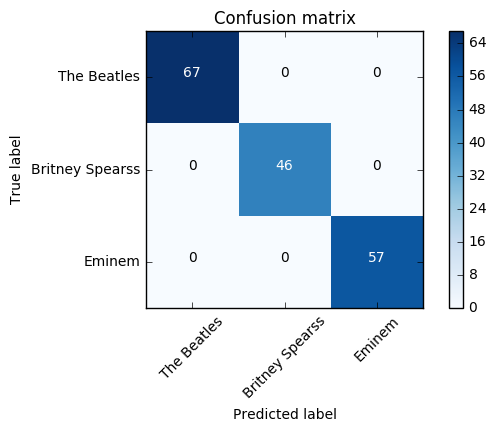

In [94]:
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues) 
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.title('Confusion matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

y_pred = rf.predict(data_features)
labels = ["The Beatles", "Britney Spearss", "Eminem"]
conf_mat = confusion_matrix(label_list, y_pred, labels=labels)
plot_confusion_matrix(conf_mat, labels)

We can see that all songs were classified correctly, which means that our RandomForest model from the last part indeed had high level of accuracy, and our RNN models successfully learned the artists songs and generated songs the look exactly like their original songs, from the machine's point of view - which is what we tried to achieve.